**Self learning notebook for NLP**

![twitter banner](https://www.e-learningmatters.com/wp-content/uploads/2016/10/Twitter-banner.jpg)

# Introduction

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

## Covered Topics
1. Data preprocessing
    * for Exploratory Data Analysis : I'll import dataset into pandas DataFrame for better understanding
    * for modelling : this will be done in tensorflow
1. Exploratory Data Analysis
1. Model building using Tensorflow

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import csv
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/standford-glove/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


## Data Preprocessing

Tweet data is stored in ***train.csv*** file, we'll read it into 2 lists of ...
1. tweets : contains each tweet message
1. labels : contains label of "0" (not disaster) or "1" (disaster) corresponding to each tweet message in tweets list

I've included preprocessing step to filter out url from tweet message if they have any.

I've also try to filter out stopwords (which is listed below) from tweet and train the model. The outcome is not promising, Therefore, I decide to keep stopwords in tweet message as it be.

In [2]:
tweets = [] 
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

train_with_stopwords = False

with open("../input/nlp-getting-started/train.csv") as csvfile: #iterate in csv files and extract tweets and relevant labels
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) #skip table header
    for row in reader:
        labels.append(int(row[4]))
        url = re.compile(r'https?://\S+|www\.\S+') #remove url if any in tweet message.
        tweet = url.sub(r'',row[3])
        if train_with_stopwords == True:
            for word in stopwords:
                token = " " + word + " "
                tweet = tweet.replace(token, " ")
        tweets.append(tweet)
print(f'Total training set = {len(tweets)} tweets')
print(f'Total training set = {len(labels)} tweets')

Total training set = 7613 tweets
Total training set = 7613 tweets


For training and evaluating, I've splited full training set into
1. Training set : 6,000 tweets and labels for model training purpose
1. Validation set : the rest (7,613-6,000 = 1,613 tweets) for evaluating and fine tuning the model

After we tune the model to have desired performance, I'll train the model again on full training set

In [3]:
#for total number of training size = 7613 tweets, first let's train on 6,000 samples and validate on 1,613 samples. After fine tuning model until it reach desired performance, later we'll train on total training set.
train_tweets , val_tweets, train_labels , val_labels = train_test_split(tweets,labels, train_size = 6000 , stratify = labels, random_state=42)
print(f'Training set size = {len(train_tweets)}')
print(f'Validation set size = {len(val_tweets)}')

Training set size = 6000
Validation set size = 1613


Now we've come to the main preprocessing steps before feeding into the model.

1. We use [keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to tokenize words in tweet message into number (which can be understood by computer).
1. By calling [.fit_on_texts](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts) method on full training set (tweets) tokenizer object will fit itself on training set and generate dictionary of key value pair which keys is words and value is index corresponding to each word (when we don't specify num_words argument while construcing tokenizer object it will have total unique word from tweets in its dictionary).
1. By calling [.texts_to_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) method on tweets list (both training and validation set) will convert sentence into sequences of number according to tokenizer dictionary.
1. Finally, we call [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) method on train and validation sequences to pad it to have same length as our max_length parameter specified.

In [4]:
embedding_dim = 100 #to match with glove model we import
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index
vocab_size = len(word_index) #set vocab size to maximum

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)

val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)

## Exploratory Data Analysis

We focus on analysis on full training set. It's my intention to not include test set in analysis to minimize chance of information leakage.

In [6]:
sns.set(style = 'darkgrid',
       context = 'notebook',
       palette = 'muted',
       )
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

In [7]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')
df['length'] = df['text'].str.len() # compute tweet message count
df['word_counts'] = df['text'].str.split().apply(len)
df.head()

,id,keyword,location,text,target,length,word_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16


This notebook will focus on analyzing tweet message, Therefore I'll drop "keyword" and "location" attribute out of our consideration

In [8]:
print(f"Training dataset shape\n {df.shape[0]} rows, {df.shape[1]} columns")
print('\nTotal missing values')
print(df.isnull().sum())
df = df.drop(columns = ['keyword','location'])

Training dataset shape
 7613 rows, 7 columns

Total missing values
id                0
keyword          61
location       2533
text              0
target            0
length            0
word_counts       0
dtype: int64


In [9]:
word_count = tokenizer.word_counts
word_count_sorted = {k:v for k,v in sorted(word_count.items(),reverse=True,key=lambda item: item[1])}
most_common_word = []
most_common_word_count = []
i = 0
for k,v in word_count_sorted.items():
    if i == 20:
        break
    most_common_word.append(k)
    most_common_word_count.append(v)
    i += 1

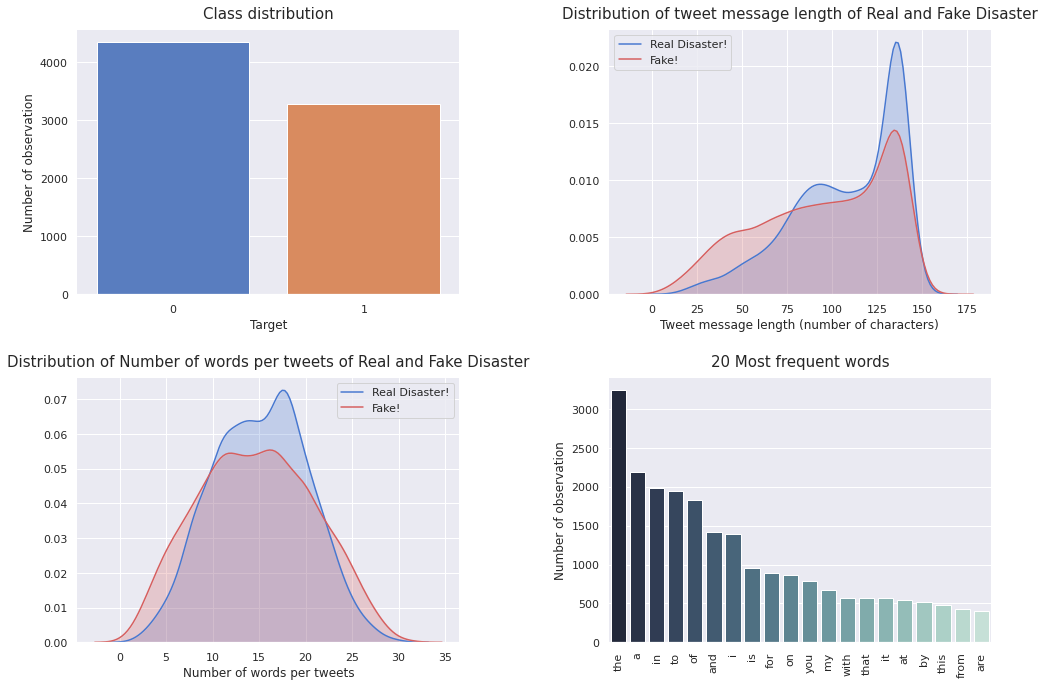

In [10]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.despine(left=True)

#Class distribution graph
ax1 = sns.countplot(x='target',data=df, ax = axes[0,0])
ax1.set_title('Class distribution',size = 15, y = 1.02)
ax1.set_xlabel('Target')
ax1.set_ylabel('Number of observation')

#Distribution of tweet message length of Real and Fake Disaster
ax2 = sns.kdeplot(df[df['target'] == 1].length ,shade = True, label = 'Real Disaster!' ,color ='b', ax=axes[0,1])
ax3 = sns.kdeplot(df[df['target'] == 0].length , shade = True, label = 'Fake!', color = 'r', ax=axes[0,1])
ax2.set_xlabel('Tweet message length (number of characters)')
ax2.set_title('Distribution of tweet message length of Real and Fake Disaster',size = 15, y = 1.02)

#Distribution of Number of words per tweets of Real and Fake Disaster
ax3 = sns.kdeplot(df[df['target'] == 1].word_counts ,shade = True, label = 'Real Disaster!' ,color ='b', ax=axes[1,0])
ax4 = sns.kdeplot(df[df['target'] == 0].word_counts , shade = True, label = 'Fake!', color = 'r', ax=axes[1,0])
ax3.set_xlabel('Number of words per tweets')
ax3.set_title('Distribution of Number of words per tweets of Real and Fake Disaster',size = 15, y = 1.02)

#Word counts
ax5 = sns.barplot(x=most_common_word,y=most_common_word_count,
            palette = sns.cubehelix_palette(n_colors=20,rot=-.3,reverse=True), ax=axes[1,1])
ax5.set_xticklabels(ax5.get_xticklabels(),
                  rotation=90);
ax5.set_ylabel('Number of observation')
ax5.set_title('20 Most frequent words',size = 15, y = 1.02)

plt.tight_layout(pad=2.0);

* In training set, we've comparative amount of Real and Fake news. There should not be any problem with class imbalance
* In aspect of tweet message length, there is no significant different between real and fake disaster. Both of them median around 135 charaters
* For number of words per tweet, for average both real and fake disaster tweet has around 10-20 words per tweets. However, there is no significant different for distribution of each group 

# Modeling

I decided to use pretrianed word vectors from [GloVe : Global Vectors for Word Representation from Stanford university](https://nlp.stanford.edu/projects/glove/) 

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

*Please note that, we use glove6B with 100-dimensional vector for our training.*

In [11]:
#Special thanks to Laurence Moroney for his hosted site for easier download

#This block of code simply map our words in tokenizer to 100-dimensional vectors with pretrained weight
embeddings_index = {};
with open('../input/standford-glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

## Baseline model

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
def plot_lr_lc(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs=range(len(acc)) # Get number of epochs
    
    #------------------------------------------------
    # Plot learning rate vs loss to find optimal learning rate
    #------------------------------------------------
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-5, 10, 0, 1])
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title(str(history))    
    plt.figure()
    
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.axis([0,80,0,1])
    plt.figure()
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])
    plt.axis([0,80,0,5])
    plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#hyperparameter to tune
l2_weight = 0.01
dropout_rate = 0.3
initial_lr = 0.001

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: initial_lr * 10**(epoch/20))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length = max_length, weights = [embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(LSTM(32,dropout = dropout_rate)),
    tf.keras.layers.Dense(8, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l2_weight)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', 
              optimizer = tf.keras.optimizers.SGD(lr=initial_lr ,momentum=0.9) ,
              metrics=['accuracy']
             )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1809800   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            8016      
_________________________________________________________________
dropout (Dropout)            (None, 46, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 16)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [14]:
num_epochs = 50
history = model.fit(train_padded, np.array(train_labels), epochs=num_epochs, 
                    validation_data=(val_padded, np.array(val_labels)), 
                    verbose=1,
                   callbacks = [lr_schedule]
                   )

Epoch 1/50
188/188 [==============================] - 3s 14ms/step - loss: 0.8088 - accuracy: 0.5668 - val_loss: 0.7900 - val_accuracy: 0.5753
Epoch 2/50
188/188 [==============================] - 1s 8ms/step - loss: 0.7765 - accuracy: 0.6073 - val_loss: 0.7524 - val_accuracy: 0.6441
Epoch 3/50
188/188 [==============================] - 2s 9ms/step - loss: 0.7363 - accuracy: 0.6762 - val_loss: 0.7062 - val_accuracy: 0.7142
Epoch 4/50
188/188 [==============================] - 2s 8ms/step - loss: 0.6930 - accuracy: 0.7283 - val_loss: 0.6579 - val_accuracy: 0.7570
Epoch 5/50
188/188 [==============================] - 1s 8ms/step - loss: 0.6519 - accuracy: 0.7507 - val_loss: 0.6178 - val_accuracy: 0.7688
Epoch 6/50
188/188 [==============================] - 1s 8ms/step - loss: 0.6132 - accuracy: 0.7622 - val_loss: 0.5887 - val_accuracy: 0.7855
Epoch 7/50
188/188 [==============================] - 1s 8ms/step - loss: 0.5890 - accuracy: 0.7672 - val_loss: 0.5531 - val_accuracy: 0.7923
Epoch

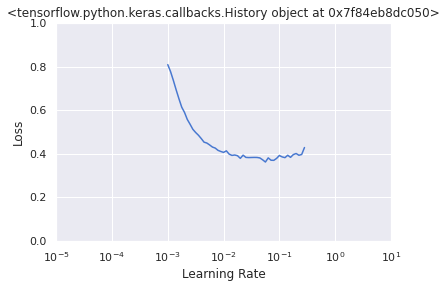

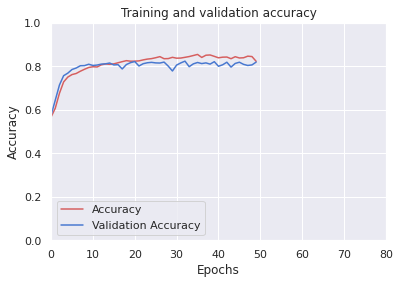

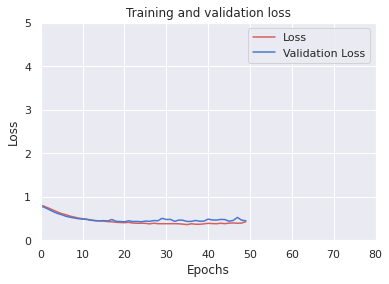

<Figure size 432x288 with 0 Axes>

In [15]:
plot_lr_lc(history)

It's been observed that. With learning rate ~ 3x10^-2, the model tend to have lowest loss and more stable than larger learning rate. 

However our model able to reach highest accuracy around 80%

## Train final model

Let's train our model with optimal learning rate (3x10^-2) and see if we can improve the performance

At this time, I also set 2 callback event for training
1. EarlyStopping callback : to save training time if there is no performance improvement
1. ModelCheckpoint callback : to load model weight which result in lowest validation accuracy

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#hyperparameter to tune
l2_weight = 0.01
dropout_rate = 0.3

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,embedding_dim,input_length = max_length, weights = [embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(LSTM(32,dropout = dropout_rate)),
    tf.keras.layers.Dense(8, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l2_weight)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.SGD(lr=3e-2 ,momentum=0.9) ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1809800   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            8016      
_________________________________________________________________
dropout (Dropout)            (None, 46, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 16)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [17]:
num_epochs = 100


#Early stop the training if there's no improvement in model performance for 20 epochs
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


#Reduce model learning rate if validation loss reach plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=20, min_lr=0.001)

#Checkpoint callback for model with lowest validation accuracy
checkpoint_filepath = 'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    save_best_only=True)


history = model.fit(train_padded, np.array(train_labels), epochs=num_epochs, 
                    validation_data=(val_padded, np.array(val_labels)), 
                    verbose=1,
                    callbacks= [early,model_checkpoint_callback]
                   )

Epoch 1/100
188/188 [==============================] - 2s 11ms/step - loss: 0.6237 - accuracy: 0.7238 - val_loss: 0.5354 - val_accuracy: 0.7557
Epoch 2/100
188/188 [==============================] - 1s 8ms/step - loss: 0.4977 - accuracy: 0.7750 - val_loss: 0.4799 - val_accuracy: 0.7898
Epoch 3/100
188/188 [==============================] - 2s 8ms/step - loss: 0.4633 - accuracy: 0.7962 - val_loss: 0.4398 - val_accuracy: 0.8165
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 0.4576 - accuracy: 0.8022 - val_loss: 0.4358 - val_accuracy: 0.8153
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 0.4327 - accuracy: 0.8160 - val_loss: 0.4509 - val_accuracy: 0.8103
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 0.4284 - accuracy: 0.8175 - val_loss: 0.4298 - val_accuracy: 0.8184
Epoch 7/100
188/188 [==============================] - 1s 8ms/step - loss: 0.4182 - accuracy: 0.8217 - val_loss: 0.4335 - val_accuracy: 0.815

<Figure size 432x288 with 0 Axes>

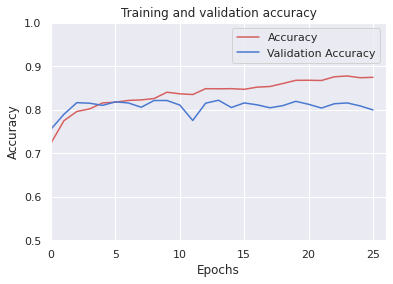

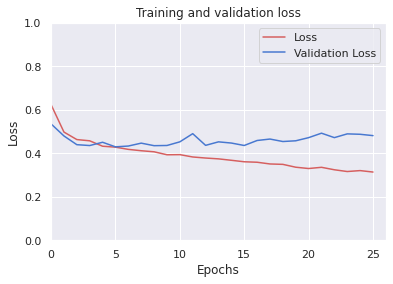

<Figure size 432x288 with 0 Axes>

In [18]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
# lr = history.history['lr']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot lr change vs epoch
#------------------------------------------------
# plt.plot(epochs,lr)
# plt.title('lr change vs epoch')
# plt.xlabel("Epochs")
# plt.ylabel("learning rate")
# plt.figure()

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.axis([0,len(history.history['loss']),.5,1])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.axis([0,len(history.history['loss']),0,1])
plt.figure()

After training for 6 epochs, model training loss continue to decrease. On the other hand, validation loss start to break away. This is a sign of model are going to overfit on training set. So I decide to stop the training and load weights of the model at the time which model has lowest validation loss.

## Prediction on test set

Let's make prediction on test set and see how our model perform

In [19]:
model.load_weights(r'./' + checkpoint_filepath)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoint

In [20]:
#load test set with same preprocessing steps as training set
tweets_test = [] 
ids = []
with open("../input/nlp-getting-started/test.csv") as csvfile: #iterate in csv files and extract tweets and relevant labels
    reader = csv.reader(csvfile, delimiter=',')
    next(reader) #skip table header
    for row in reader:
        ids.append(int(row[0]))
        url = re.compile(r'https?://\S+|www\.\S+') #remove url if any in tweet message.
        tweet = url.sub(r'',row[3])
        tweets_test.append(tweet)
print(f'Total training set = {len(tweets_test)} tweets')
print(f'Total training set = {len(ids)} tweets')

Total training set = 3263 tweets
Total training set = 3263 tweets


In [21]:
test_sequences = tokenizer.texts_to_sequences(tweets_test)
test_padded = pad_sequences(test_sequences, padding = padding_type, truncating = trunc_type, maxlen = max_length)

In [22]:
y_predict = model.predict(test_padded)
y_predict = np.round(y_predict,0).astype(int).flatten()

In [23]:
submission = pd.DataFrame({'id' : ids, 'target' : y_predict})
print(submission.head())
submission.to_csv('submission.csv',index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


With model trained on part of training set our model have reached about 80.2% accuracy on test set which is pretty good enough

## Train model on full training set

Now, it's time to train our model on full training set and see if it could learn more!

In [24]:
train_tweets_full = np.vstack((train_padded,val_padded))
train_labels_full = np.concatenate((np.array(train_labels),np.array(val_labels)))

In [25]:
num_epochs = 30

history = model.fit(train_tweets_full, train_labels_full, epochs=num_epochs, 
                    verbose=1,
                   )

Epoch 1/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3545 - accuracy: 0.8570
Epoch 2/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3416 - accuracy: 0.8621
Epoch 3/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3414 - accuracy: 0.8626
Epoch 4/30
238/238 [==============================] - 2s 8ms/step - loss: 0.3313 - accuracy: 0.8681
Epoch 5/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3201 - accuracy: 0.8746
Epoch 6/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3200 - accuracy: 0.8755
Epoch 7/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3168 - accuracy: 0.8721
Epoch 8/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3174 - accuracy: 0.8736
Epoch 9/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3062 - accuracy: 0.8818
Epoch 10/30
238/238 [==============================] - 2s 7ms/step - loss: 0.3033 - accuracy: 0.8830

In [26]:
y_predict_full = model.predict(test_padded)
y_predict_full = np.round(y_predict_full,0).astype(int).flatten()

In [27]:
submission_full = pd.DataFrame({'id' : ids, 'target' : y_predict_full})
print(submission_full.head())
submission_full.to_csv('submission_full.csv',index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1


Our model have improved in another step. At time of submission model has accuracy about 83% on test set.

# Conclusion

So far we've developed a model to classify whether a tweeted tweet will be real disaster or not. With existing progress we are able to reach 83% accuracy on test set which is quite good. However I can identify some room for improvement as follow...

* try removing some uninterpretable phrases/words likes \x89ÛÓ or \x89Û_
* try different network architecture
* try different pretrained weight from GloVe variances